## Problem Set 1. Mean-Variance Analysis

Code for the Chicago Booth course on Quantitative Portfolio Management by Ralph S.J. Koijen and Federico Mainardi.

### Overview

In this notebook, we'll start to work with Python. This first problem set helps us to construct the efficient frontier and the capital market line. 
- You can download the data from: https://www.dropbox.com/scl/fo/hrjspow2cpstfnoeqb23v/h?rlkey=j4fohf1s4e6fdy49p7bs71b7l&dl=0.
- Please copy the file in the Data folder: `MeanVarianceSample.parquet` to a local folder. 

Every box that has "[]:" in front of it needs to be run. To run it, put your cursor in the box and then push the "play button" on top. Alternatively, you can press "shift+enter" (or "shift+return" on a Mac).

We proceed in five steps:

1. Initialize Python. There are some basic lines of code that we always start with. 
2. We load returns on two securities: Amazon (ticker: AMZN) and Goldman Sachs (ticker: GS).
3. We compute the returns of portfolios that combine the two securities with different weights.
4. We compute the means and variances of the portfolio returns from step 3. This gives us the efficient frontier.
5. We compute the capital market line (CML) by combining the risk-free rate (which we set to zero, consistent with the short-term interest rate during most of our sample period) and the efficient portfolio.

Let's get started!

### Step 1: Initializing Python.

Python uses libraries with pre-coded functions that make it really easy to compute all the statistics we need, such as means, variances, et cetera. In this problem set, we use the following three lines. Now run this first block. If this works, the message "Python is ready to go!" appears.

In [1]:
# Load the relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wrds

print('Python is ready to go!')

Python is ready to go!


Before we get started, make sure to select the desired procedure to import the data by setting `import_data` equal to True or False. If `import_data` = True, then the code will download the data directly from WRDS. If `import_data` = False, the code loads data available in Dropbox. If `import_data` = False is chosen, make sure to enter the path to your directory that contains the data that you download from WRDS.

In [2]:
import_data = True          # <-- Edit this line
_DATA_DIR = '../Data'       # <-- Edit this line

### Step 2: Loading the data.

Let's first load the data. 

In [3]:
if import_data == True:

    # Establish connection with wrds
    db = wrds.Connection() 

    # Define your SQL statement
    df = db.raw_sql("""
                        SELECT a.permno, a.date, a.prc, a.cfacshr, b.ticker
                        FROM crsp_m_stock.msf as a
                        LEFT JOIN crsp_m_stock.msenames as b
                        ON a.permno=b.permno AND b.namedt<=a.date AND a.date<=b.nameendt
                        WHERE a.date >= '2007-01-01' AND a.date <= '2023-07-31' AND (b.ticker = 'SPY' OR b.ticker = 'AMZN' OR b.ticker = 'GS')
                    """)
    
    # Reformat date
    df['ym'] = pd.to_datetime(df['date'])
    
    # Adjust prices for stock splits and reverse splits
    df['prc'] = df['prc']/df['cfacshr']
    
    # Select the variables of interest: The date (ym), ticker, and price (prc)
    df = df[['ym','ticker','prc']] 
    
if import_data == False:
    
    # Load dataset
    df = pd.read_parquet('%s/MeanVarianceSample.parquet' %(_DATA_DIR))
    
    # Minor adjustments
    df = df[df['ym'] >= '2007-01-01'] # Sample to 2007 and beyond
    df = df[['ym','ticker','prc']] # Restrict attention to variables of interest: Date, Ticker and Price
    

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


The following lines of code select the data of historical monthly prices for the ETF SPY (ticker: SPY) that tracks the S&P500. This price is not yet adjusted for dividends, which we will do in future analyses as we build our backtesting model. To be precise, returns are defined as
$$
R(t+1) = \frac{P(t+1)+D(t+1)}{P(t)},
$$
where $R(t)$ is the return, $P(t)$ the price, and $D(t)$ the dividend. In the calculations below, we use the capital gain, $\frac{P(t+1)}{P(t)}$ as a proxy for the return. We'll refine this later and add dividends as well. 

The data contain prices not only for `SPY` but other stocks as well. The code

`df[df.TICKER = 'SPY']`

selects elements of `df` where the `ticker` column equals `SPY`. It then sets the `ym` variable, which contains the monthly dates, as the index and selects the `prc` column which contains information on the prices. To get data for different stocks, one can simply replace `SPY` with the ticker of choice.

At any point, you can see what's in the dataset by printing the first couple of lines by the command `print(SPY.head())`. The default is 5. If you'd like to see more lines, let's say 10 lines, you can use `print(SPY.head(10))`. Similarly, if you'd like to see the last lines, you use `print(SPY.tail())`.

In [4]:
SPY = df[df.ticker == 'SPY'].set_index('ym')['prc']
print(SPY.tail())

ym
2023-03-31    409.390015
2023-04-28    415.929993
2023-05-31    417.850006
2023-06-30    443.279999
2023-07-31    457.790009
Name: prc, dtype: float64


Let's plot the price index. The first two lines of code construct the graph. The next four lines provide the labels for the axes, the legend, and then we plot the figure.

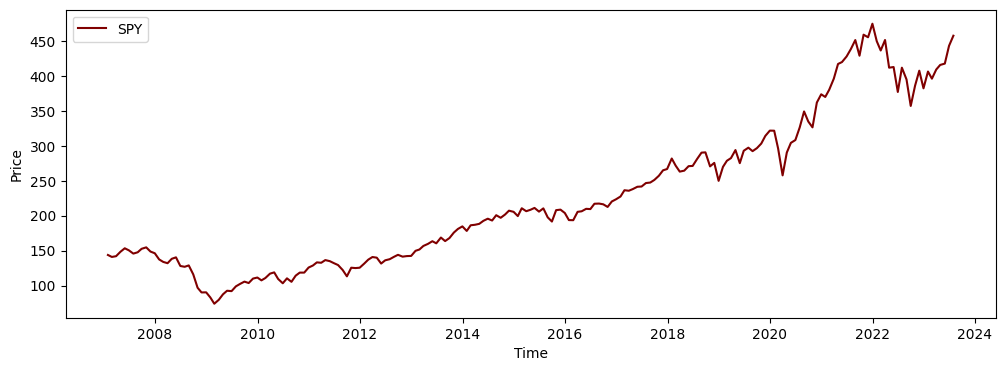

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (12, 4))
plt.plot(SPY.index, SPY.values, color = 'maroon')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(['SPY']);

Next, we want to compute returns. As discussed, we compute returns as R(t) = P(t)/P(t-1)-1. The code `SPY.shift(1)` shifts the data one month backwards.

In [6]:
SPY_ret = SPY/SPY.shift(1)-1

print(SPY_ret.head(3))

ym
2007-01-31         NaN
2007-02-28   -0.019617
2007-03-30    0.007592
Name: prc, dtype: float64


As you can see, we created a missing value (NaN) for the first observation. After all, we do not have the price before January 2007. To get rid of it, we can start our return series one month later and drop the first observation. In Python, the index of a table starts at 0. Hence, we want to start our data from index 1. The code 

`SPY_ret = SPY_ret[1:]`

selects all data starting at the second observation. Let's try it!

In [7]:
SPY_ret = SPY_ret[1:]
print(SPY_ret.head(3))

ym
2007-02-28   -0.019617
2007-03-30    0.007592
2007-04-30    0.044296
Name: prc, dtype: float64


There is a more efficient way to compute returns now that we understand the mechanics. The following line of code computes the percent difference, just like we did before, and drops the first observation:

In [8]:
SPY_ret = SPY.pct_change()[1:]
print(SPY_ret.head(3))

ym
2007-02-28   -0.019617
2007-03-30    0.007592
2007-04-30    0.044296
Name: prc, dtype: float64


We're now ready for the first part of our problem set. In the box below, write the following code:

1. Select the data for the two stocks in two variables, called `AMZN` and `GS`.
2. Compute the returns in `AMZN_ret` and `GS_ret` and drop the first observation.

==> Q1: Report the first three prices of Amazon and Goldman (January, February, and March of 2007).

In [14]:


# Get the data for Amazon
AMZN = df[df.ticker == 'AMZN'].set_index('ym')['prc']

# Get the data for Goldman Sachs
GS = df[df.ticker == 'GS'].set_index('ym')['prc']

# Compute the returns for Amazon
AMZN_ret = AMZN / AMZN.shift(1) - 1

# Compute the returns for Goldman Sachs
GS_ret = GS / GS.shift(1) - 1

# Drop the January 2007 return
AMZN_ret = AMZN_ret[1:]
GS_ret = GS_ret[1:]

# Q1: Report the returns of Amazon and Goldman for Feb, Mar, and Apr 2007
print("Amazon returns for Feb, Mar, and Apr 2007:")
print(AMZN_ret['2007-02':'2007-04'].head(3))

print("\nGoldman returns for Feb, Mar, and Apr 2007:")
print(GS_ret['2007-02':'2007-04'].head(3))


Amazon returns for Feb, Mar, and Apr 2007:
ym
2007-02-28    0.039023
2007-03-30    0.016607
2007-04-30    0.541342
Name: prc, dtype: float64

Goldman returns for Feb, Mar, and Apr 2007:
ym
2007-02-28   -0.049067
2007-03-30    0.024188
2007-04-30    0.057978
Name: prc, dtype: float64


Now let's plot the price series of both stocks. If all variables are computed correctly, you can run the plot below. 

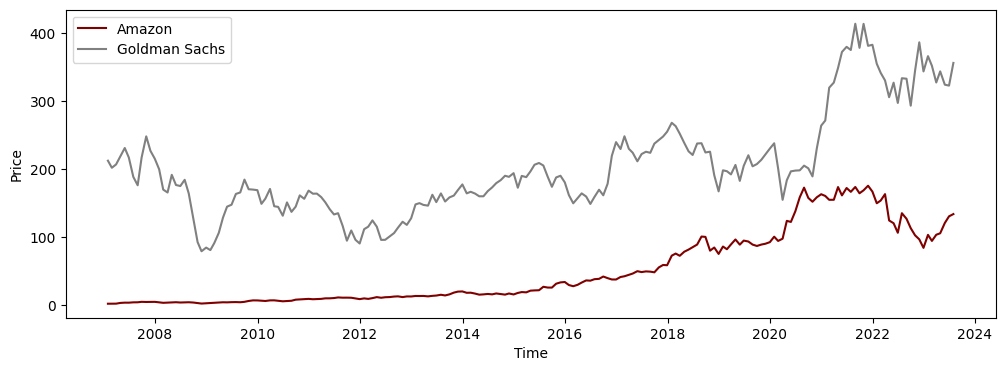

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (12, 4))
plt.plot(AMZN.index, AMZN.values, color = 'maroon')
plt.plot(GS.index, GS.values, color = 'gray')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(['Amazon','Goldman Sachs']);

==> Q2: Save the figure in your problem set.

Next, we want to combine both securities into a portfolio and find the efficient frontier. Here, we use a trick called "loops." Instead of manually computing lots of different combinations of the portfolio, we can use just a couple of lines of code to do this for us.

Let's consider a simple example of a loop. Suppose we want to consider 3 portfolios: (100%,0%), (50%,50%), and (0%, 100%). We can do this via:

In [16]:
for w in range(0,3):
    weight = w * 0.5
    print(weight)

0.0
0.5
1.0


The first line tells us the values w will take. In this case, 0, 1, and 2. Then we define the weight in steps of 50%. The last line, like we have seen before, prints the value of the portfolio weight.

There is an important note here: The loop executes all lines that are indented. If they're not indented, they'll not be executed as part of the loop.

Next, we want to compute the portfolio return in each step of the loop. The return on the portfolio is:

return_portfolio = weight * AMZN_ret + (1-weight) * GS_ret"

That is, we take the weighted average of both returns. 

Once we have the portfolio return, we want to compute the mean and the standard deviation. Remember we started with the first couple of lines of code? We need these packages now. Pyhton has lots of useful functions already programmed for you (just like Excel). We now want to know the mean and the standard deviation of our portfolio.

The mean is computed as np.mean() and the standard deviation as np.std(). We put them together in a row of a table with the portfolio weight first.

In [17]:
for w in range(0,3):
    weight = w * 0.5
    return_portfolio = weight * AMZN_ret + (1-weight) * GS_ret
    print([weight, np.mean(return_portfolio), np.std(return_portfolio)])

[0.0, 0.006730808643199543, 0.09053001930890991]
[0.5, 0.01666829311191292, 0.07846643184126771]
[1.0, 0.026605777580626298, 0.10074452260135609]


Instead of printing each line, we'd like to store the results so we plot it easily. We can do this using the "append" command. 

We start from two empty lists (portfolio_mean and portfolio_std). Then in every iteration of the loop, we add the mean and standard deviation, respectively.

In [18]:
portfolio_mean = []
portfolio_std = []

for w in range(0,3):
    weight = w * 0.5
    return_portfolio = weight * AMZN_ret + (1-weight) * GS_ret
    portfolio_mean.append(np.mean(return_portfolio))
    portfolio_std.append(np.std(return_portfolio))


Now let's plot the minimum-variance frontier! 

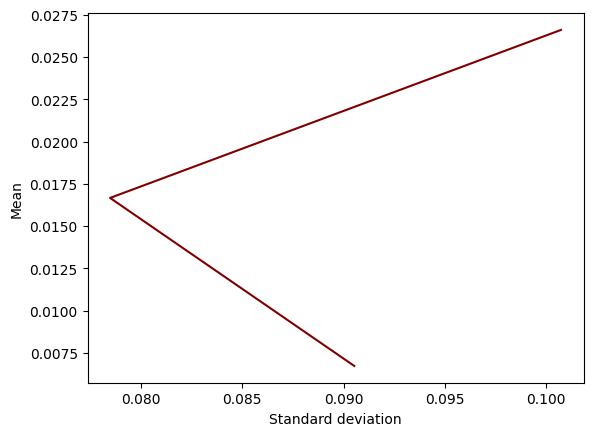

In [19]:
plt.plot(portfolio_std, portfolio_mean, color = 'maroon')
plt.xlabel('Standard deviation')
plt.ylabel('Mean');

That starts to look like a minimum-variance frontier. However, as we only compute 3 portfolios, the line doesn't look very smooth. So let's now take steps of 5%. In the box below, adjust the code so that the loop takes steps from 0%, 5%, ..., 100%.

In [20]:
## Enter code here
portfolio_mean = []
portfolio_std = []

for w in range(0,21):
    weight = w * 0.05
    return_portfolio = weight * AMZN_ret + (1-weight) * GS_ret
    portfolio_mean.append(np.mean(return_portfolio))
    portfolio_std.append(np.std(return_portfolio))


If this all worked out, the code below should give you a smooth efficient frontier.

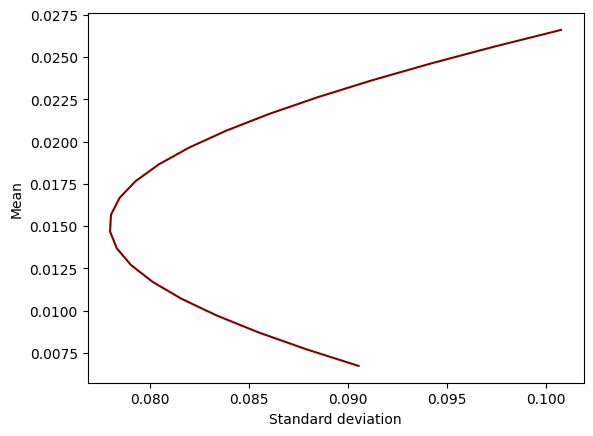

In [21]:
plt.plot(portfolio_std, portfolio_mean, color = 'maroon')
plt.xlabel('Standard deviation')
plt.ylabel('Mean');

==> Q3: Copy the plot of the efficient frontier to your problem set. 

However, you can see that the curve abruptly ends. We need to short a stock to complete the curve. We can do this by extending the loop. Below the code for weights ranging from (-100%,200%), (-90%,190%), ..., (200%,-100%). Hence, each portfolio adds up to 100%. The code below does exactly that.

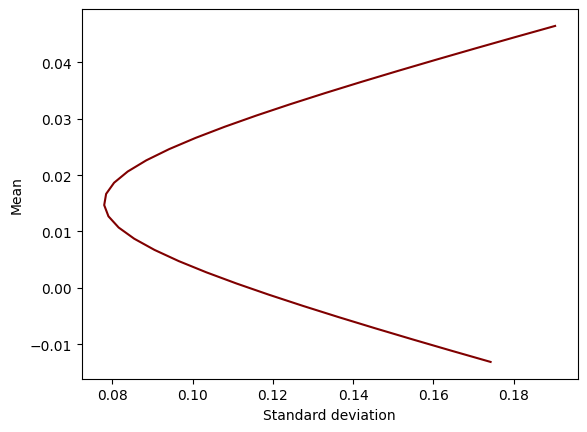

In [22]:
portfolio_mean = []
portfolio_std = []

for w in range(0,31):
    weight = w * 0.10 - 1
    return_portfolio = weight * AMZN_ret + (1-weight) * GS_ret
    portfolio_mean.append(np.mean(return_portfolio))
    portfolio_std.append(np.std(return_portfolio))
    
plt.plot(portfolio_std, portfolio_mean, color = 'maroon')
plt.xlabel('Standard deviation')
plt.ylabel('Mean');

Lastly, we want to construct the capital market line. The capital market line combines the risk-free rate (zero in this problem set) and the combination of both stocks with the highest possible Sharpe ratio. Recall that the Sharpe ratio is defined as (E(r)-rf) / stdev(r). So let's add the Sharpe ratio to the loop.

The last line selects the portfolio that maximizes the Sharpe ratio.

In [23]:
portfolio_mean = []
portfolio_std = []
portfolio_weight = []
portfolio_SR = []

for w in range(0,31):
    weight = w * 0.10 - 1
    return_portfolio = weight * AMZN_ret + (1-weight) * GS_ret
    portfolio_mean.append(np.mean(return_portfolio))
    portfolio_std.append(np.std(return_portfolio))
    portfolio_weight.append(weight)
    portfolio_SR.append(np.mean(return_portfolio)/np.std(return_portfolio))
    
result = np.column_stack((portfolio_weight, portfolio_mean, portfolio_std, portfolio_SR))
result = pd.DataFrame(result, columns = ['weight','mean','stdev','SR'])
print(result.to_string(index=False))    

 weight      mean    stdev        SR
   -1.0 -0.013144 0.174260 -0.075428
   -0.9 -0.011157 0.164511 -0.067817
   -0.8 -0.009169 0.154927 -0.059184
   -0.7 -0.007182 0.145541 -0.049345
   -0.6 -0.005194 0.136394 -0.038082
   -0.5 -0.003207 0.127537 -0.025143
   -0.4 -0.001219 0.119034 -0.010242
   -0.3  0.000768 0.110968  0.006924
   -0.2  0.002756 0.103440  0.026642
   -0.1  0.004743 0.096577  0.049114
    0.0  0.006731 0.090530  0.074349
    0.1  0.008718 0.085472  0.102002
    0.2  0.010706 0.081587  0.131219
    0.3  0.012693 0.079049  0.160575
    0.4  0.014681 0.077989  0.188243
    0.5  0.016668 0.078466  0.212426
    0.6  0.018656 0.080455  0.231879
    0.7  0.020643 0.083846  0.246203
    0.8  0.022631 0.088480  0.255773
    0.9  0.024618 0.094173  0.261417
    1.0  0.026606 0.100745  0.264092
    1.1  0.028593 0.108036  0.264665
    1.2  0.030581 0.115910  0.263832
    1.3  0.032568 0.124257  0.262103
    1.4  0.034556 0.132988  0.259841
    1.5  0.036543 0.142032  0.257289
 

The table portfolio_SR contains the Sharpe ratio of each portfolio. Let's plot it to see what it looks like.

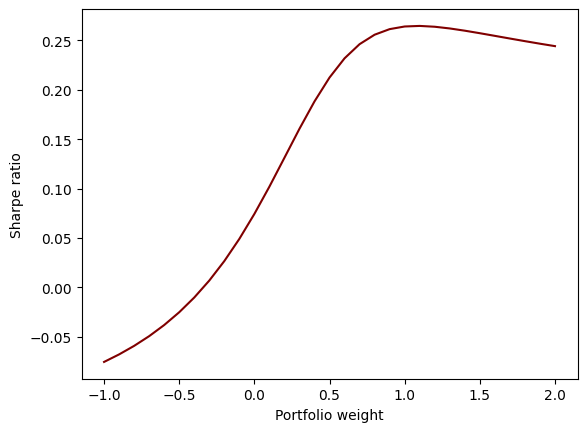

In [24]:
plt.plot(portfolio_weight, portfolio_SR, color = 'maroon')
plt.xlabel('Portfolio weight')
plt.ylabel('Sharpe ratio');

Now instead of reading off the figure what the efficient portfolio is, let's do this using Python. 

The code `portfolio_SR.index(max(portfolio_SR))` returns the line of the table that contains the maximum Sharpe ratio. Then we look up in the table "portfolio_weight" what the corresponding weight is.



In [25]:
SR_maximum = max(portfolio_SR)
print("Optimal portfolio weight:", portfolio_weight[portfolio_SR.index(SR_maximum)])

Optimal portfolio weight: 1.1


==> Q4: Provide the economic interpretation of this portfolio; how do we implement it?

To complete this exercise, we plot the capital market line.

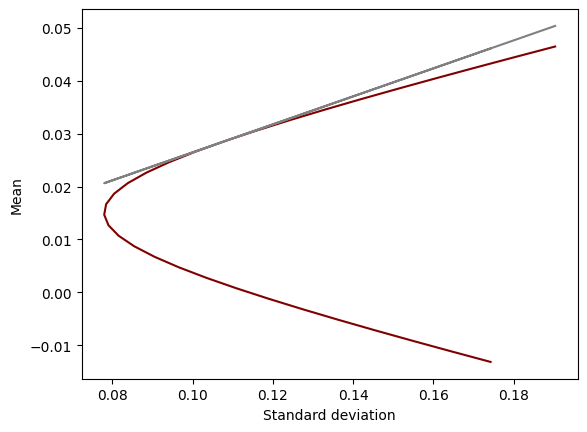

In [26]:
portfolio_mean = []
portfolio_std = []
mean_CML = []

for w in range(0,31):
    weight = w * 0.10 - 1
    return_portfolio = weight * AMZN_ret + (1-weight) * GS_ret
    portfolio_mean.append(np.mean(return_portfolio))
    portfolio_std.append(np.std(return_portfolio))
    mean_CML.append(SR_maximum * np.std(return_portfolio))
    
plt.plot(portfolio_std, portfolio_mean, color = 'maroon')
plt.plot(portfolio_std, mean_CML, color = 'gray')
plt.xlabel('Standard deviation')
plt.ylabel('Mean')

plt.show(); plt.close()

==> Q5: Save the figure in your problem set.

Done!